MLE λ̂ = 4.865
Wald 95% CI: (4.559314727516381, 5.170685272483619)
Garwood Poisson-based 95% CI: (4.564077700686579, 5.180550186631559)
Chi-square GOF: χ² = 7.16, df = 7, p-value = 0.412
Sample mean = 4.865, sample variance = 5.062


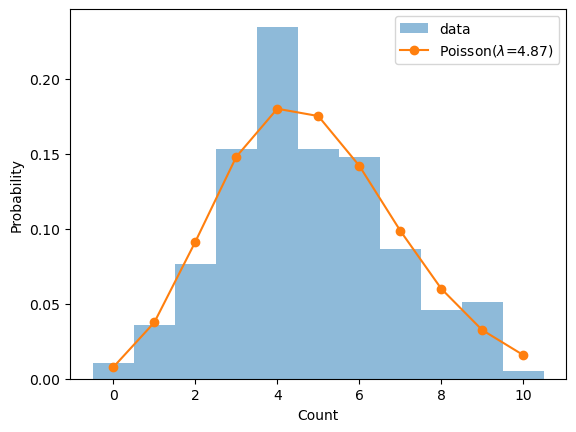

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

def estimate_lambda_ci(data, alpha=0.05):
    n = len(data)
    lam_hat = np.mean(data)
    # Wald CI
    se = np.sqrt(lam_hat / n)
    z = st.norm.ppf(1 - alpha/2)
    ci_lower = lam_hat - z * se
    ci_upper = lam_hat + z * se
    # Ensure non-negative lower bound
    ci_lower = max(ci_lower, 0)
    return lam_hat, (ci_lower, ci_upper)

def garwood_poisson_interval(sum_x, n, alpha=0.05):
    # sum_x = sum of counts, total exposure = n
    # This gives CI for lambda = (sum_x)/n
    lower = 0.5 * st.chi2.ppf(alpha/2, 2 * sum_x) / n
    upper = 0.5 * st.chi2.ppf(1 - alpha/2, 2 * sum_x + 2) / n
    return lower, upper

def goodness_of_fit_chisq(data, lam_hat, max_count=20):
    # Observed frequencies (0, 1, 2, ..., max_count, >max_count)
    obs_counts = np.bincount(data)
    # Extend or trim to length max_count+1, then add tail
    if len(obs_counts) <= max_count:
        obs = np.concatenate([obs_counts, [0]])
    else:
        tail = np.sum(obs_counts[max_count+1:])
        obs = np.concatenate([obs_counts[:max_count+1], [tail]])

    # Expected frequencies under Poisson(λ̂)
    probs = [st.poisson.pmf(k, lam_hat) for k in range(max_count+1)]
    probs_tail = 1.0 - sum(probs)
    probs.append(probs_tail)
    exp = np.array(probs) * len(data)

    # Keep bins with expected > 5 for validity of chi-square approx
    mask = exp > 5
    chi2 = np.sum(((obs - exp)**2 / exp)[mask])
    df = np.sum(mask) - 1 - 1  # minus 1 param estimated
    pval = 1 - st.chi2.cdf(chi2, df)

    return chi2, df, pval, obs, exp


def plot_goodness(data, lam_hat, max_k=15):
    # histogram + overlay Poisson pmf
    plt.hist(data, bins=np.arange(0, max_k+2)-0.5, density=True, alpha=0.5, label='data')
    ks = np.arange(0, max_k+1)
    pmf = st.poisson.pmf(ks, lam_hat)
    plt.plot(ks, pmf, 'o-', label=f'Poisson($\lambda$={lam_hat:.2f})')
    plt.xlabel('Count')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

def main():
    # simulate data
    np.random.seed(123)
    true_lambda = 5.0
    n = 200
    data = np.random.poisson(lam=true_lambda, size=n)
    
    lam_hat, (ci_l, ci_u) = estimate_lambda_ci(data)
    print("MLE λ̂ =", lam_hat)
    print("Wald 95% CI:", (ci_l, ci_u))
    # Garwood
    lower_g, upper_g = garwood_poisson_interval(sum(data), n)
    print("Garwood Poisson-based 95% CI:", (lower_g, upper_g))
    
    # goodness-of-fit
    chi2, df, pval, obs, exp = goodness_of_fit_chisq(data, lam_hat, max_count=10)
    print(f"Chi-square GOF: χ² = {chi2:.2f}, df = {df}, p-value = {pval:.3f}")
    
    # dispersion check
    var = np.var(data, ddof=1)
    mean = np.mean(data)
    print("Sample mean = {:.3f}, sample variance = {:.3f}".format(mean, var))
    
    plot_goodness(data, lam_hat, max_k=10)

if __name__ == "__main__":
    main()
